In [ ]:
import tensorflow as tf
from pathlib import Path
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)
quickdraw_dir = Path(filepath).parent

In [ ]:
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)[:3]
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

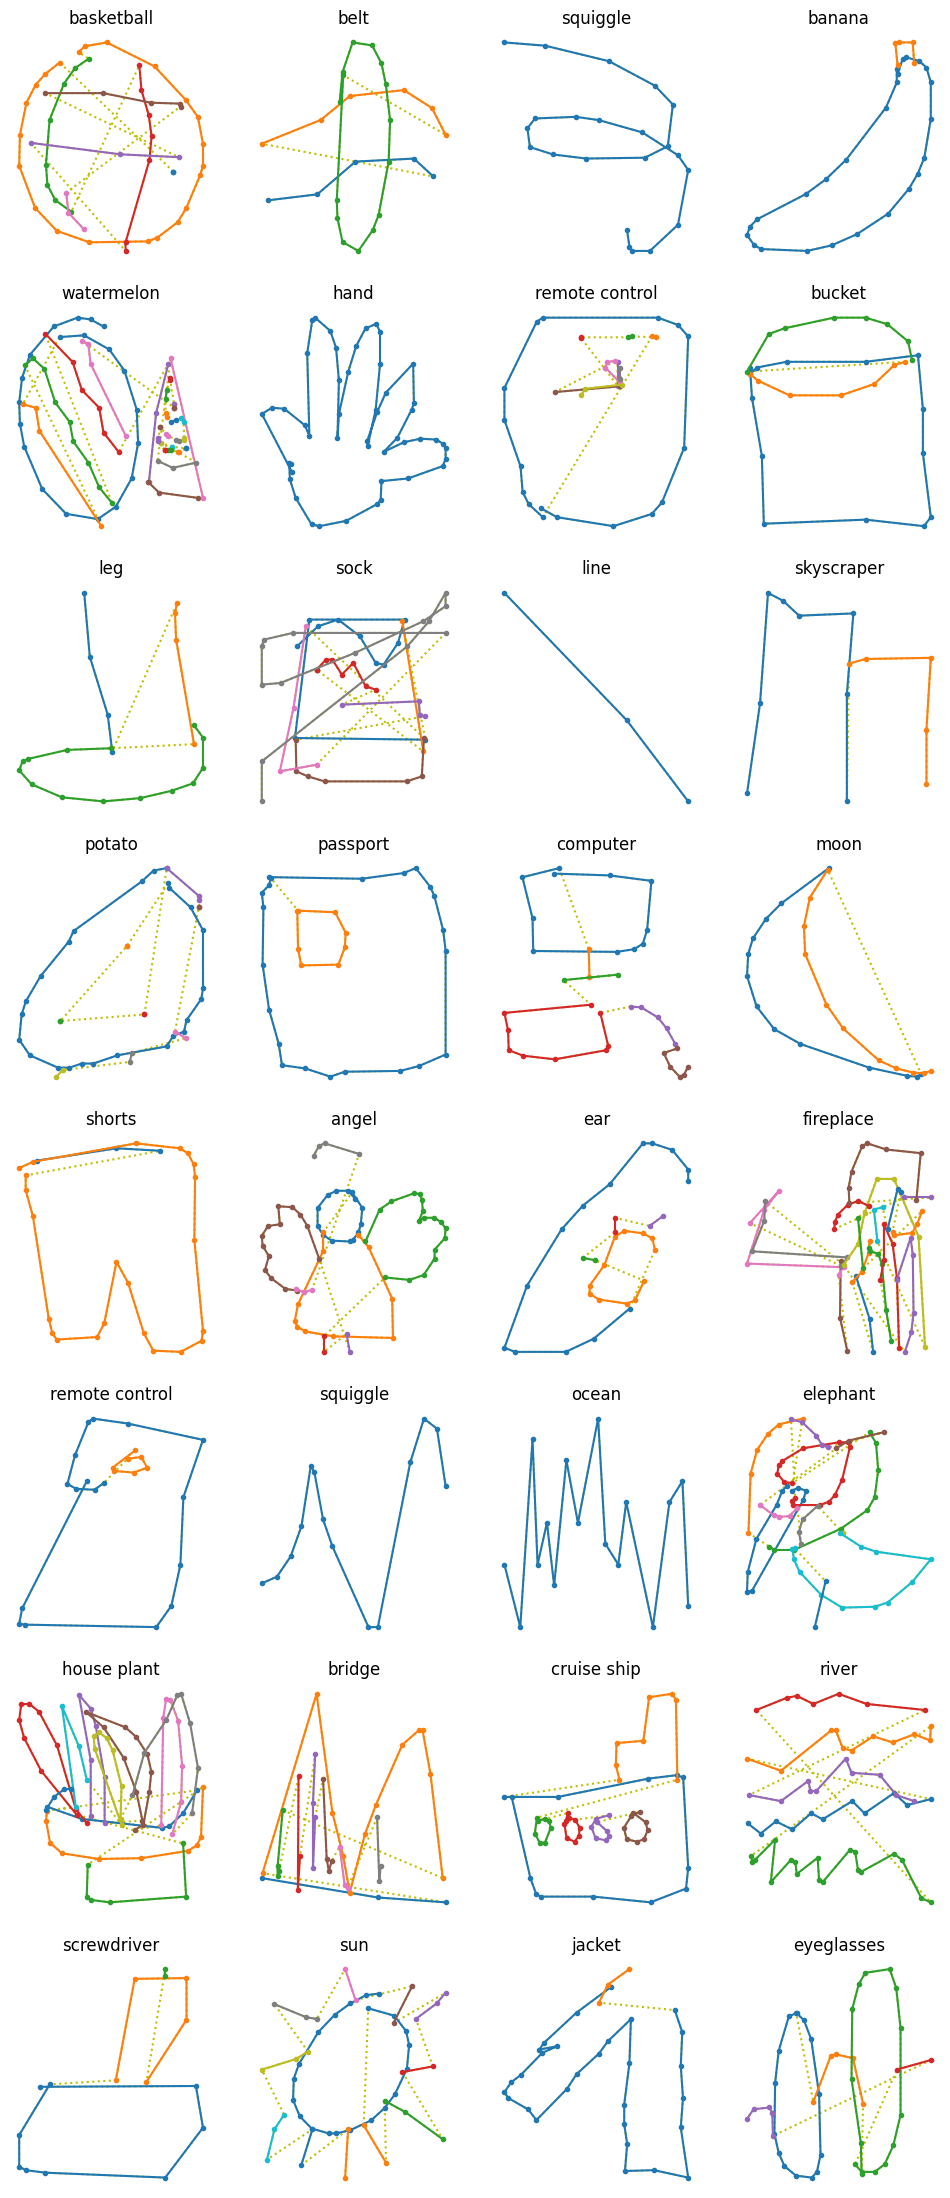

1/1 [==============================] - 1s 945ms/step


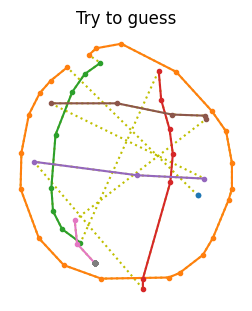

Top-5 predictions:
  1. basketball 9.821%
  2. onion 4.883%
  3. tennis racquet 4.615%
  4. baseball 4.122%
  5. watermelon 3.986%
Answer: basketball


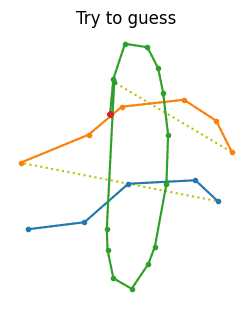

Top-5 predictions:
  1. shorts 2.565%
  2. pants 2.519%
  3. ice cream 2.307%
  4. hourglass 2.234%
  5. lipstick 2.188%
Answer: belt


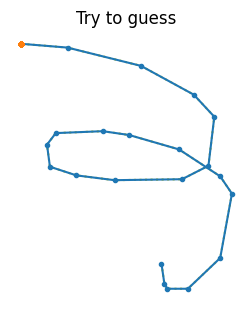

Top-5 predictions:
  1. paper clip 5.669%
  2. sock 3.088%
  3. boomerang 2.503%
  4. ear 2.307%
  5. shoe 2.251%
Answer: squiggle


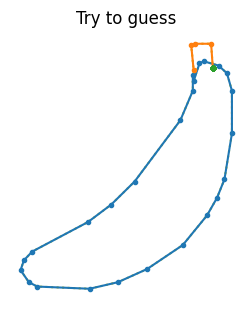

Top-5 predictions:
  1. circle 7.783%
  2. potato 5.576%
  3. pear 4.990%
  4. peanut 4.940%
  5. moon 4.839%
Answer: banana


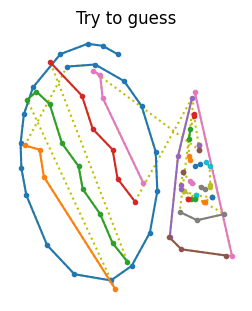

Top-5 predictions:
  1. tennis racquet 2.663%
  2. tiger 2.457%
  3. hedgehog 2.414%
  4. brain 2.299%
  5. zebra 2.266%
Answer: watermelon


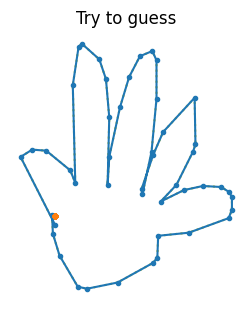

Top-5 predictions:
  1. hand 7.578%
  2. tornado 3.393%
  3. tree 3.310%
  4. saw 3.118%
  5. squiggle 2.862%
Answer: hand


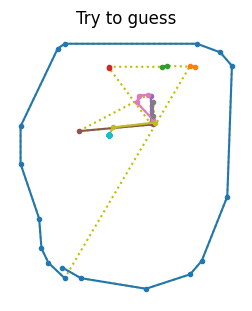

Top-5 predictions:
  1. cake 3.804%
  2. remote control 3.655%
  3. birthday cake 3.356%
  4. map 2.295%
  5. television 2.091%
Answer: remote control


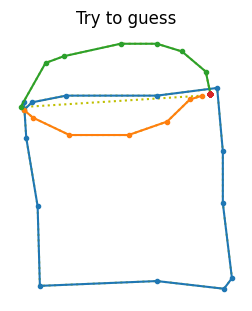

Top-5 predictions:
  1. picture frame 6.694%
  2. envelope 5.219%
  3. microwave 4.320%
  4. oven 3.808%
  5. television 3.403%
Answer: bucket


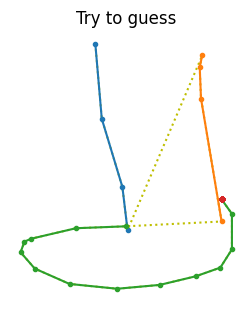

Top-5 predictions:
  1. wine bottle 3.064%
  2. sock 2.791%
  3. baseball bat 2.749%
  4. shorts 2.523%
  5. boomerang 2.194%
Answer: leg


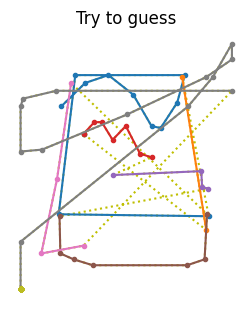

Top-5 predictions:
  1. book 3.568%
  2. fence 1.916%
  3. sandwich 1.910%
  4. couch 1.865%
  5. calendar 1.512%
Answer: sock


In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]
sorted(class_names)

def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=1,
                    validation_data=cropped_valid_set)

y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))